In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy.signal import convolve2d
from utils.parallel.ConvLayerPara import ConvLayerP
%load_ext autoreload
%autoreload 2

In [9]:
def testing_parallel(layer, N, C, M, H, W, K):
    x_shape = (N, C,H,W)
    m_shape = (M,C,K,K)
    X = np.random.rand(*x_shape).astype(np.float32)
    Masks = np.random.rand(*m_shape).astype(np.float32)

    _, t_naive = layer.forward_naive(X, Masks, N, C, M, H, W, K)

    _, t_shared = layer.forward_shared(X, Masks, N, C, M, H, W, K)

    t_sample_naive = 0
    for i in range(N):
        _, t_temp_naive = layer.forward_sample_naive(X[i], Masks, C, M, H, W, K)
        t_sample_naive += t_temp_naive

    t_sample_shared = 0
    for i in range(N):
        _, t_temp_shared = layer.forward_sample_shared(X[i], Masks, C, M, H, W, K)
        t_sample_shared += t_temp_shared

    return t_naive, t_shared, t_sample_naive, t_sample_shared


def testing_serial(layer, N, C, M, H, W, K, t_serial):
    x_shape = (N, C,H,W)
    m_shape = (M,C,K,K)
    X = np.random.rand(*x_shape).astype(np.float32)
    Masks = np.random.rand(*m_shape).astype(np.float32)
    
    _, t_serial = layer.forward_serial(X, Masks, N, C, M, H, W, K)

    return t_serial


def test_parallel(N_list, loop_time):

    layer = ConvLayerP()
    C, M, H, W, K = 3, 16, 32, 32, 10

    t_naive = []
    t_shared = []
    t_sample_naive = []
    t_sample_shared = []
    t_serial = []

    for n in N_list:
        print('N: ', n)
        t_naive += [0]
        t_shared += [0]
        t_sample_naive += [0]
        t_sample_shared += [0]
        t_serial += [0]
        for _ in range(loop_time):
            result = testing_parallel(layer, n, C, M, H, W, K)
            t_naive[-1] += result[0]/loop_time
            t_shared[-1] += result[1]/loop_time
            t_sample_naive[-1] += result[2]/loop_time
            t_sample_shared[-1] += result[3]/loop_time

    return t_naive, t_shared, t_sample_naive, t_sample_shared


def test_serial(N_list, loop_time):

    layer = ConvLayerP()
    C, M, H, W, K = 3, 16, 32, 32, 10

    t_serial = []

    for n in N_list[:4]:
        if n <= 2:
            print('N: ', n)
            t_serial += [0]
            for _ in range(loop_time):
                result = testing_serial(layer, n, C, M, H, W, K, t_serial)
                t_serial[-1] += result/loop_time
    
    return t_serial

In [10]:
N_list = [1,2,4,8,16,32,64,128,256,512,1024]
loop_time = 10
t_naive, t_shared, t_sample_naive, t_sample_shared = test_parallel(N_list, loop_time)

N:  1
N:  2
N:  4
N:  8
N:  16
N:  32
N:  64
N:  128
N:  256
N:  512
N:  1024


In [11]:
t_serial = test_serial(N_list, loop_time)

N:  1
N:  2


In [12]:
np.save('./data/t_naive.npy', np.array(t_naive))
np.save('./data/t_shared.npy', np.array(t_shared))
np.save('./data/t_sample_naive.npy', np.array(t_sample_naive))
np.save('./data/t_sample_shared.npy', np.array(t_sample_shared))
np.save('./data/t_serial.npy', np.array(t_serial))



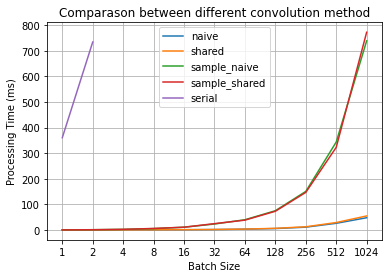

In [13]:

plt.figure()
plt.plot(t_naive, label='naive')
plt.plot(t_shared, label='shared')
plt.plot(t_sample_naive, label='sample_naive')
plt.plot(t_sample_shared, label='sample_shared')
plt.plot(t_serial, label='serial')
plt.xticks(range(len(N_list)), N_list)
plt.grid()
plt.ylabel('Processing Time (ms)')
plt.xlabel('Batch Size')
plt.title('Comparason between different convolution method')
plt.legend();
plt.savefig('./data/conv_withserial.png')

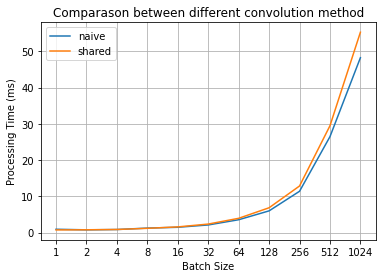

In [14]:
plt.figure()
plt.plot(t_naive, label='naive')
plt.plot(t_shared, label='shared')
plt.xticks(range(len(N_list)), N_list)
plt.grid()
plt.ylabel('Processing Time (ms)')
plt.xlabel('Batch Size')
plt.title('Comparason between different convolution method')
plt.legend();
plt.savefig('./data/conv_batch.png')

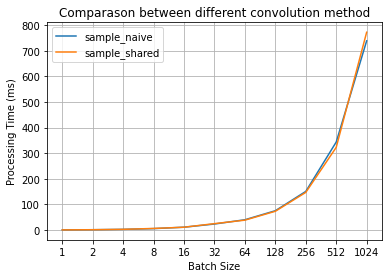

In [15]:
plt.figure()
plt.plot(t_sample_naive, label='sample_naive')
plt.plot(t_sample_shared, label='sample_shared')
plt.xticks(range(len(N_list)), N_list)
plt.grid()
plt.ylabel('Processing Time (ms)')
plt.xlabel('Batch Size')
plt.title('Comparason between different convolution method')
plt.legend();
plt.savefig('./data/conv_sample.png')

In [13]:
batch = 1000
C, M, H, W, K = 3, 3, 128, 128, 3

x_shape = (batch, C,H,W)
m_shape = (M,C,K,K)
y_shape = (batch, M, H-K+1, W-K+1)

X = np.random.rand(*x_shape).astype(np.float32)
print('Shape of X: ', X.shape)
Masks = np.random.rand(*m_shape).astype(np.float32)
print('Shape of Masks: ', Masks.shape)

Shape of X:  (1000, 3, 128, 128)
Shape of Masks:  (3, 3, 3, 3)


In [18]:
layer = ConvLayerP()
for i in range(batch):
    Y_sample_sahred = layer.forward_sample_shared(X[i], Masks, C, M, H, W, K)

In [5]:
layer = ConvLayerP()

Y_naive = layer.forward_naive(X, Masks, batch, C, M, H, W, K)
print(Y_naive.shape)
# print(Y_naive)

(32, 32, 1)
(2, 3, 4)
(2, 3, 63, 63)


In [5]:
layer = ConvLayerP()

Y_shared = layer.forward_shared(X, Masks, batch, C, M, H, W, K)
print(Y_shared.shape)
print(Y_shared)



Block:  (32, 32, 1)
Grid:  (1000, 3, 16)
sharedmem:  4660 Byte
(1000, 3, 126, 126)
[[[[7.549174   6.7277594  5.8029695  ... 6.741596   5.9617243
    6.192018  ]
   [4.845324   2.9781     6.973196   ... 6.0805006  5.011341
    5.971016  ]
   [4.9553337  2.7108836  5.9631977  ... 5.4173903  5.0405893
    6.173236  ]
   ...
   [4.887554   1.7476386  6.7087626  ... 6.581533   5.8476834
    5.214723  ]
   [4.4104886  1.7199509  7.196432   ... 5.244977   6.2033973
    6.212957  ]
   [4.769962   1.9473916  7.5131364  ... 5.637623   6.1410747
    6.205826  ]]

  [[5.5872993  2.1310399  5.1400485  ... 4.1776466  5.2308083
    4.809724  ]
   [3.5964904  1.2265097  1.4145409  ... 1.6886785  1.3710936
    1.6059567 ]
   [1.1568091  0.2721266  7.6042128  ... 6.7183166  6.8893013
    7.58477   ]
   ...
   [5.6464863  2.360147   8.796903   ... 7.3505726  6.627256
    6.999948  ]
   [5.497767   1.9313958  9.006899   ... 6.9564347  7.3519163
    7.5038877 ]
   [5.0266685  2.1553342  7.9220033  ... 6.37

In [10]:
layer = ConvLayerP()
batch = 1000

for i in range(batch):
    _ = layer.forward_sample_naive(X[i], Masks, C, M, H, W, K)
# Y_sample_naive = layer.forward_sample_naive(X[0], Masks, C, M, H, W, K)
# print('Shape of X: ', X[0].shape)
# print('Shape of Y', Y_sample_naive.shape)
# print(Y_sample_naive)


In [9]:
layer = ConvLayerP()

batch = 16

print(X.shape)
print(Masks.shape)

Y_serial = layer.forward_serial(X, Masks, batch, C, M, H, W, K)

(1000, 3, 128, 128)
(3, 3, 3, 3)


In [56]:
a = []
a.append(0)
print(a)
a += [0]
a+=[0]
print(a)

[0]
[0, 0, 0]
